In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = Path("../src/data/pizza_steak_sushi/")
image_path

WindowsPath('../src/data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('../src/data/pizza_steak_sushi/train'),
 WindowsPath('../src/data/pizza_steak_sushi/test'))

In [5]:
IMG_SIZE = 224 # From table 3 in the ViT paper

manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
manual_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

In [6]:
# From data_loader.py
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def create_dataloaders(train_dir: str, 
                      test_dir:str, 
                      transform: transforms,
                      batch_size: int,
                      ):
    NUM_WORKERS = os.cpu_count()
    train_data = datasets.ImageFolder(
        root=train_dir, 
        transform=transform,
    )
    test_data = datasets.ImageFolder(
        root=test_dir, 
        transform=transform,
    )

    class_names = train_data.classes

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x270a0e790f0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

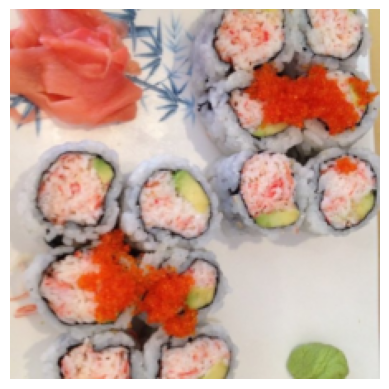

sushi


In [9]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.show()
print(class_names[label])

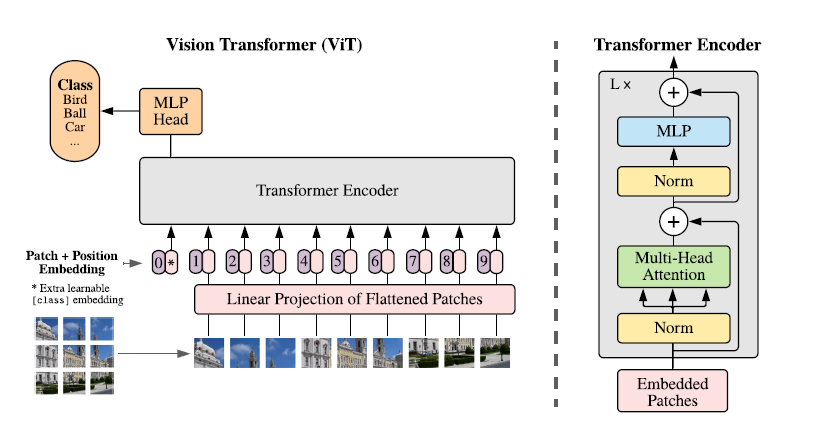

- Patch + Position Embeddings (Inputs) : Turns a full image into many patches and then set a positional index to specify the order where the patch came in.
- Linear Projection of Flattened Patches (Embeddiing Patches): Turns an image into an embedding. Why use embedding? It's because embedding is a learnable representation, it's usually in the form of a vector of the said image.
- Transformaton Encoder : This encoder comprises of layers that are listed above. There's 2 "skip connections" (The one that has "+" in it) that meant the layer's input will be fed into an immediate layer of that connections and the one that came after it.
    - Norm: This is a Normalization Layer. This layers perform regularization to handle overfitting. In pytorch we can use `torch.nn.LayerNorm()`
    - Multi-Head Attention (MSA): Multi-headed self attention is a module for attention mechanism that are run through multiple attention mechanism in parallel. The output of the attention mechanism then are concatenated and then transformed into the expected dimension. Multiple attention heads in this context allows for attending the parts of the sequent differently. (Shorter-term dependencies and Longer-term dependencies).
    - Multi-layer Perceptron (MLP) : An MLP layer consists of multiple forward layer (or forward() method in pytorch's case). In the paper, the author refer to the MLP as "MLP Block". In this block, it contains two layers of Linear function and with GELU (Gaussian Error Linear Units) activation function in between them for non-linearity and Dropout layer after each of them.
- MLP Head : This is the output layer of the architecture. It converts the input of the learned features into a class of output. This is the "Classifier" of the model. The structure of MLP Head is similar to MLP Block.


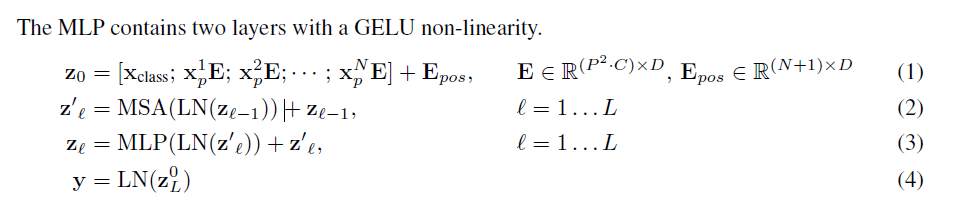
These four equations represent the maths behind the major p


- $\mathbf{z_0}$ : Embedded patches
- $\mathbf{E}$ : Embedding
- $\mathbf{E_{Pos}}$ : Position Embedding
- $\mathbf{z}_{\ell}$ : z of a particular layer.
- $MSA$ : Multi-head Attention
- $MLP$ : Multi-layer Perceptron
- $LN$  : LayerNorm
- $\mathbf{y}$   : Overall output of the architecture


This is texts taken from the Paper.
- (Eq. 1) : ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings...
- (Eq. 2) : The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).
- (Eq. 3) : The same as (Eq. 2)
- (Eq. 4) : Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)...

## In a form of code (Simplified)

### eq 1 

`x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]`


### eq 2

`x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input`

### eq 3
`x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block`

### eq 4 
`y = Linear_layer(LN_layer(x_output_MLP_block[0]))`

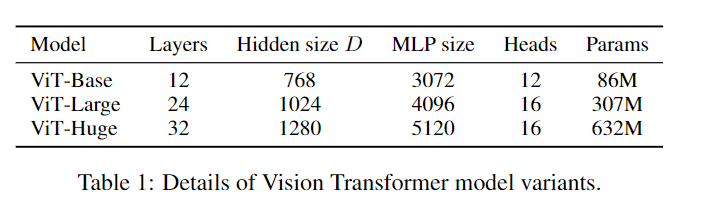

This is the hyperparameter of the models, it increased from the base model to ViT-Huge. For this experiment, it will use just the base model.

Table 1:
- Layer : Number of transformer encoder block
- Hidden Size ($D$) : Embedding dimension (The shape / size of the vector the image will be turned into). The larger the dimension, the more information that can be captured and it may lead to better result. But it will cost more computational power. 
    - The image starts as 2D with size ${H \times W \times C}$. 
        - $(H, W)$ is the resolution of the input image. 
        - $C$ is the number of channels (Color channels (R,G,B)). 
    - The image gets converted to a sequence of flattened 2D patches with the size of ${N \times\left(P^{2} \cdot C\right)}$. 
        - $(P, P)$ is the resolution of the image patch. 
        - $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer
- MLP Size : Number of hidden units of MLP layer
- Heads : Number of heads in the Multi-Head Attention Layers
- Params : Total number of parameters in the model. The bigger the number, the better the performance and also more computation.

In [10]:
height, width, channel = 224, 224, 3
patch_size = 16

num_of_patches = int((height * width) / patch_size ** 2)

print(f'Number of patches : {num_of_patches} from image with height of H={height} and width of W={width} and patch size of P={patch_size}')


Number of patches : 196 from image with height of H=224 and width of W=224 and patch size of P=16


In [11]:
embedding_layer_input_shape = (height, width, channel)
embedding_layer_output_shape = (num_of_patches, patch_size ** 2 * channel)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


# Patcher

## Turning Image into Patches (Manual)

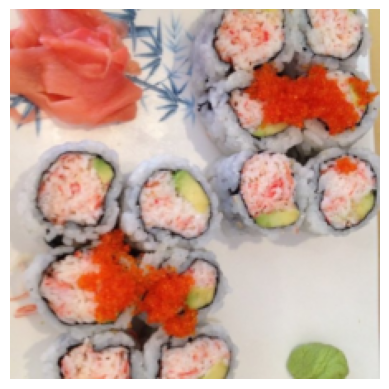

sushi


In [12]:
plt.imshow(image.permute(1,2,0))
plt.axis(False)
plt.show()
print(class_names[label])

Top Row of the image


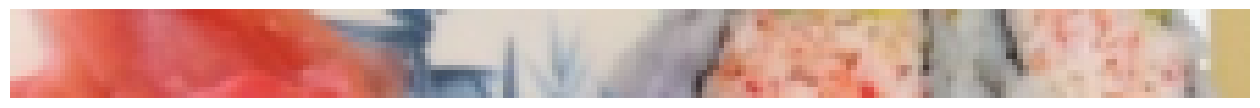

In [13]:
image_permuted = image.permute(1,2,0)

patch_size = 16 
plt.figure(figsize=(patch_size, patch_size))
plt.axis(False)
plt.imshow(image_permuted[:patch_size, : , :])
print('Top Row of the image')

Number of patches per row = 14, patch_size = 16 pixels x 16 pixels


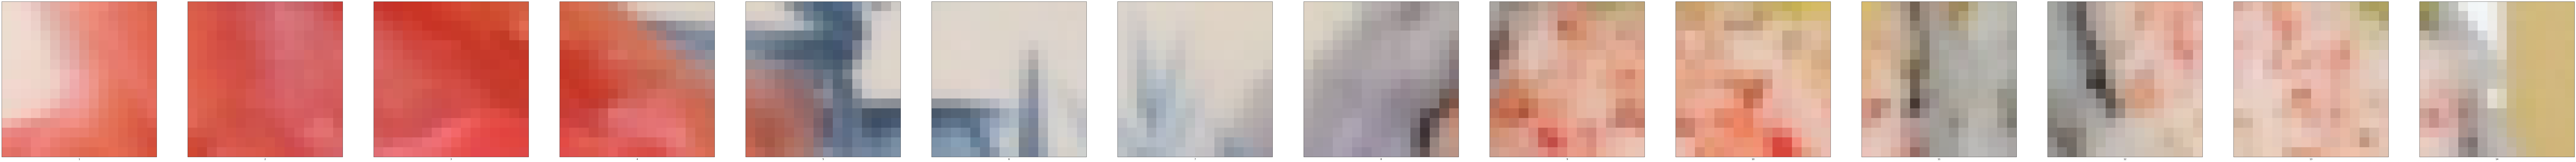

In [14]:
img_size = 224
patch_size = 16

num_patches = img_size // patch_size

assert img_size % patch_size == 0, "Image size must be divisible by the patch_size"

print(f"Number of patches per row = {num_patches}, patch_size = {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=num_patches,
                        figsize=(num_of_patches, num_of_patches),
                        )

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch + patch_size, : ])
    axs[i].set_xlabel(i + 1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [15]:
img_size = 224
patch_size = 16

num_patches = img_size // patch_size

assert img_size % patch_size == 0, "Image size must be divisible by the patch_size"

print(f"Number of patches per row = {num_patches}, patch_size = {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        figsize=(num_of_patches, num_of_patches),
                        )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[
            patch_height:patch_height + patch_size, 
            patch_width:patch_width + patch_size, : ])
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_ylabel(i + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

Number of patches per row = 14, patch_size = 16 pixels x 16 pixels


## Turning image into patches (Using Convolution Layer)

In pytorch, we can recreate this by using 
- `torch.nn.Conv2D()` -> Turning the image into patches of CNN feature map
- `torch.nn.Flatten()` -> Flattening the spatial dimension of the feature map

We can recreate the previous process by setting the kernel_size and stride similar to the patch_size.

We can set the in_channel = 3 to match the color channel and the out_channels = 768, the same as the value of $D$ for ViT-Base in Table 1.

In [16]:
patch_size = 16

conv2d = nn.Conv2d(
    in_channels=3, 
    out_channels=768, 
    kernel_size= patch_size, 
    stride=patch_size,
    padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

sushi


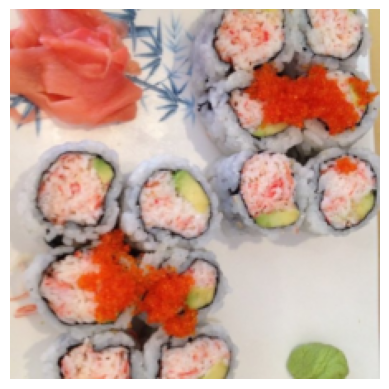

In [17]:
plt.imshow(image.permute(1,2,0))
plt.axis(False)
print(class_names[label])

In [18]:
test_patches_conv = conv2d(image.unsqueeze(0))
test_patches_conv.shape

torch.Size([1, 768, 14, 14])

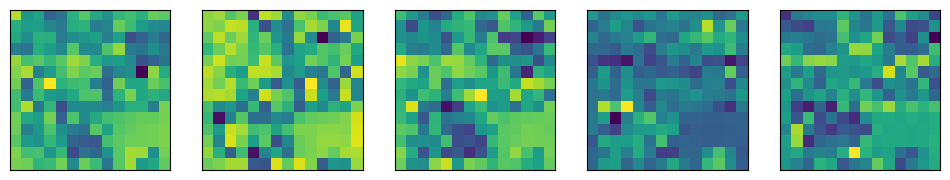

In [19]:
import random

random_indexes = random.sample(range(0, 768), k = 5)

fig, axs = plt.subplots(nrows=1, ncols=len(random_indexes), figsize=(12,12))

for i, idx in enumerate(random_indexes):
    img_conv_feature_map = test_patches_conv[ : , idx, : , : ]
    axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) 

In [20]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])


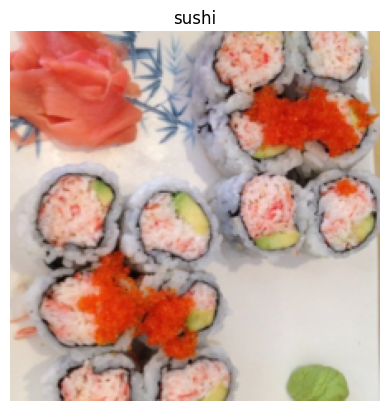

In [21]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

In [22]:
test_patches_conv_flattened = flatten(test_patches_conv)

print(f'Original Feature Map Shape {test_patches_conv.shape}')
print(f'Original Feature Map Shape {test_patches_conv_flattened.shape}')

Original Feature Map Shape torch.Size([1, 768, 14, 14])
Original Feature Map Shape torch.Size([1, 768, 196])


In [23]:
# [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
test_patches_conv_flattened = test_patches_conv_flattened.permute(0, 2 ,1) 

image shape : torch.Size([1, 196, 768])


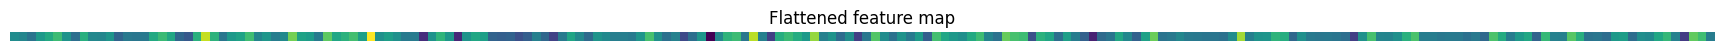

In [24]:
plt.figure(figsize=(22,22))
plt.imshow(test_patches_conv_flattened[:,:,0].detach().numpy())
plt.title(f'Flattened feature map')
plt.axis(False)
print(f'image shape : {test_patches_conv_flattened.shape}')

## ViT Patch Embedding

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(
            self, 
            in_channels:int = 3, 
            patch_size:int = 16,
            embedding_dim:int = 768):
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )
        self.flatten = nn.Flatten(
            start_dim=2,
            end_dim=3
        )

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution // patch_size, "Input image size must be divisible to patch size"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

In [26]:
test_patch = PatchEmbedding()

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = test_patch(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [27]:
from torchinfo import summary

random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)

summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## ViT Class Token Embedding

From the paper : 

*Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).*


Pseudocode of "Prepending a learnable embedding to the sequences of embedded patches"

```
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

In [28]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    torch.ones(
        batch_size, 
        1, 
        embedding_dimension), 
    requires_grad=True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [29]:
patch_embedded_image_with_class_embedding = torch.cat((class_token,patch_embedded_image),dim=1) 
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2092, -0.0805,  0.2832,  ...,  0.4813,  0.5993, -0.2310],
          [-0.1373, -0.0668,  0.1959,  ...,  0.4598,  0.4421, -0.1943],
          ...,
          [-0.1502, -0.2236,  0.2689,  ...,  0.3297,  0.3479,  0.0721],
          [-0.1545, -0.4454,  0.2062,  ...,  0.4871,  0.3376,  0.1487],
          [-0.0762, -0.3007,  0.3053,  ...,  0.6703,  0.5333, -0.0783]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [30]:
patch_embedded_image_with_class_embedding[0][0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

## ViT Positional Token Embedding

From the paper :

*Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.*



Eq. 1 states tat position embedding should have the shape of $(N + 1) \times D$

$\mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times D}$

Where : 
- N : The number of patches which is the effective length of input sequence.
- D : The size of patch embeddings / Embedding Dimension

In [31]:
number_of_patches = int((height * width) / patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

position_embedding = nn.Parameter(torch.ones(
    1, number_of_patches + 1, embedding_dimension
), requires_grad=True)


In [32]:
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [33]:
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2092, -0.0805,  0.2832,  ...,  0.4813,  0.5993, -0.2310],
         [-0.1373, -0.0668,  0.1959,  ...,  0.4598,  0.4421, -0.1943],
         ...,
         [-0.1502, -0.2236,  0.2689,  ...,  0.3297,  0.3479,  0.0721],
         [-0.1545, -0.4454,  0.2062,  ...,  0.4871,  0.3376,  0.1487],
         [-0.0762, -0.3007,  0.3053,  ...,  0.6703,  0.5333, -0.0783]]],
       grad_fn=<CatBackward0>)

In [34]:
position_embedding

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [35]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7908, 0.9195, 1.2832,  ..., 1.4813, 1.5993, 0.7690],
         [0.8627, 0.9332, 1.1959,  ..., 1.4598, 1.4421, 0.8057],
         ...,
         [0.8498, 0.7764, 1.2689,  ..., 1.3297, 1.3479, 1.0721],
         [0.8455, 0.5546, 1.2062,  ..., 1.4871, 1.3376, 1.1487],
         [0.9238, 0.6993, 1.3053,  ..., 1.6703, 1.5333, 0.9217]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Putting it together

$\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\mathrm{pos}}, \quad \mathbf{E} \in \mathbb{R}^{\left(\boldsymbol{P}^2 \cdot C\right) \times \boldsymbol{D}}, \mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times \boldsymbol{D}}$

In [36]:
from helper_functions import set_seeds

set_seeds()

patch_size = 16

print(f"Image tensor shape : {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape : {x.shape}")

patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    patch_size=patch_size,
    embedding_dim=768
)
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")


batch_size  = patch_embedding.shape[0]  
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(
        batch_size,
        1,
        embedding_dimension
    ), requires_grad = True
)
print(f"Class token embedding shape : {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

print(f"Patching embedding + Class Token Embedding shape : {patch_embedding_class_token.shape}")

num_of_patches = int((height * width) / patch_size ** 2)
position_embedding = (nn.Parameter(
torch.ones(1, num_of_patches + 1, embedding_dimension)
))

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Image tensor shape : torch.Size([3, 224, 224])
Input image with batch dimension shape : torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape : torch.Size([1, 1, 768])
Patching embedding + Class Token Embedding shape : torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Multi-Headed Self-Attention

$$ \begin{aligned} \mathbf{z^{\prime}}_{\ell} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell - 1}\right)\right)+\mathbf{z}_{\ell - 1}, & & \ell=1 \ldots L \end{aligned} $$

In [37]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, 
                 embedding_dim:int = 768,
                 num_heads:int = 12, # From Table 1 (ViT-Base)
                 attn_dropout:float = 0
                 ):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True)
        

    def forward(self, x):
        x = self.layer_norm(x)

        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output
    

In [38]:
multiheaded_self_attention_block = MultiHeadedSelfAttention(
    embedding_dim=768,num_heads=12)

patched_image_through_msa_block = multiheaded_self_attention_block(
    patch_and_position_embedding
)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


# MultiLayer Perceptron

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

"MLP" is quite broad, it can refer to any combination of multiple layers. But, it generally follows this pattern

linear layer -> non-linear layer -> linear layer -> non-linear layer

In the case of this ViT paper, it's stated in section 3.1

> The MLP Contains two layers with a GELU non-linearity

The "two layers" refer to the linear layer" and "GELU" refers to Gaussian Error Linear Units non-linear activation function.

Another thing, in section B.1 it's stated that

> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.

Meaning that at every linear / dense layer there will be a dropout layer. The value of the dropout layer can be found in Table 3. (for ViT-Base it will be `dropout = 0.1`)

As such the pattern will be like this

linear layer -> Dropout -> non-linear layer -> linear layer -> Dropout -> non-linear layer


In [39]:
class MultiLayerPerceptronBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int = 768,
                 mlp_size:int = 3072, # MLP Size from Table 1 for ViT-Base 
                 dropout:float = 0.1
                 ):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.GELU(),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x


In [40]:
mlp_block = MultiLayerPerceptronBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


# Transformer Encoder

This section is the part where we stack the MSA and MLP block to create Transformer Encoder part of ViT Architecture.

In the paper at Section 3.1 :
>  The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

From the paper we can already see that the main pattern of this encoder will be the alternating layers of MLP and MSA. What about the residual connections? Residual Connections / Skip Connections will be applied by applying the input of the MSA block to the output of the MSA block before it gets passed to the MLP block. The same things happen to the MLP block before the value gets passed to the next Transformer Block.

Pseudocode :

`
x_input -> MSA_block -> [MSA_Block_Output + x_input] -> MLP_Block -> [MLP_Block_Output + MSA_Block_Output + x_input] -> ...
`

The purpose of this method is to prevent the weight values from being to small, this allows for deeper networks and in turn allow for deeper representation to be learned.

In [41]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, 
                 embedding_dim:int=768,
                 num_heads:int = 12,
                 mlp_size:int = 3072,
                 mlp_dropout:float = 0.1,
                 attn_dropout:float = 0.0):
        super().__init__()

        self.msa_block = MultiHeadedSelfAttention(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout)
        self.mlp_block = MultiLayerPerceptronBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    def forward(self, x):
        x = self.msa_block(x) + x # residual
        x = self.mlp_block(x) + x

        return x

In [42]:
#testing

transformer_encoder_block = TransformerEncoderBlock()


summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadedSelfAttention (msa_block)             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [43]:
nn.TransformerEncoderLayer

torch.nn.modules.transformer.TransformerEncoderLayer

# Putting it all together

In [44]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size:int = 224, # Training res from Table 3
        in_channels:int=3, # Input image's color channel
        patch_size:int = 16, 
        num_transformer_layer:int = 12, # Number of transformer layer (In Table 1 for ViT-Base)
        embedding_dim: int = 768, # Hidden size D from Table 1 for Vit-Base
        mlp_size:int = 3072, # MLP Size from Table 1 for Vit-Base
        num_heads:int = 12, # Number of heads from Table 1 for ViT-Base
        attn_dropout:float = 0.0, # Dropout for attention projectoin
        mlp_dropout:float = 0.1,# Dropout for MLP Layer
        embedding_dropout:float = 0.1, # Dropout for patch and position embeddings
        num_classes:int=1000 # Default for ImageNet
    ):
        super().__init__()
        
        assert img_size % patch_size == 0, "The image size must be divisible to the patch size"

        self.num_patches = (img_size * img_size) // patch_size ** 2

        self.class_embedding = nn.Parameter(data = torch.randn(
            1,1, embedding_dim
        ), requires_grad=True)

        self.position_embedding = nn.Parameter(data = torch.randn(
            1, self.num_patches + 1, embedding_dim
        ), requires_grad=True)

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        self.transformer_encoder  = nn.Sequential(*[
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout,
                attn_dropout=attn_dropout
            ) for _ in range(num_transformer_layer)] )
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(
                in_features=embedding_dim,
                out_features=num_classes
            )
        )
    
    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 Means to infer the dimension

        x = self.patch_embedding(x) # Patch embedding

        x = torch.cat((class_token, x), dim=1) # Prepend the class token to the beginning of the patch embedding

        x = self.position_embedding + x # Add position embedding to patch embedding

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x


In [45]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768), requires_grad=True)
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)


print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [46]:
class_token_embedding_single

Parameter containing:
tensor([[[ 2.3718e-01, -1.4513e+00,  1.8592e+00,  1.2388e+00, -2.1134e-02,
           1.6731e+00,  5.3560e-01, -4.5505e-01, -8.8068e-01, -1.4200e+00,
          -1.8976e-01,  3.9031e-01,  1.4184e+00, -3.9466e-01,  3.8420e-01,
           1.7314e-01, -2.4313e-01,  8.3808e-01,  9.3824e-02, -1.0787e+00,
           5.1760e-01, -8.8413e-01,  1.5835e+00, -5.2219e-01,  7.0244e-01,
           4.3603e-01, -8.4457e-01,  2.0313e+00,  1.5077e-02,  9.5821e-01,
          -6.8766e-01,  9.2186e-01, -1.1541e-01,  1.0317e-01,  1.6328e+00,
           6.3976e-01, -6.7568e-01, -3.6942e-01,  1.1210e+00, -1.0487e+00,
           1.3382e+00,  6.8564e-01, -4.2453e-01, -2.2952e-01,  1.3890e+00,
          -4.7449e-01, -5.0479e-01,  2.2846e+00,  6.4283e-01,  2.4836e-02,
          -1.8757e+00,  9.2984e-01,  1.3121e+00, -5.1457e-01,  1.1474e+00,
          -3.2789e-01, -6.5914e-01,  4.3871e-01,  1.7588e+00,  2.1335e-01,
          -1.0996e+00, -6.3603e-01,  2.5262e-01, -8.0672e-01, -8.6713e-01,
   

In [47]:
class_token_embedding_expanded

tensor([[[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]],

        [[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]],

        [[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]],

        ...,

        [[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]],

        [[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]],

        [[ 0.2372, -1.4513,  1.8592,  ...,  0.7904, -0.0449,  0.0722]]],
       grad_fn=<ExpandBackward0>)

In [48]:
set_seeds()

vit = ViT(num_classes=len(class_names))

random_image_tensor = torch.randn(1, 3, 224, 224)

vit(random_image_tensor)

tensor([[0.1794, 0.6157, 1.0731]], grad_fn=<AddmmBackward0>)

In [49]:
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Optimizer

Section 4.1 on Training & Fine-Tuning

> *Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with $\beta_{1}=0.9, \beta_{2}=0.999$, a batch size of 4096 and apply a high weight decay of $0.1$, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).*

So we can use "Adam" as the optimizer when training as it produces slightly better performance compared to "SGD".

The author use a $\beta$ values for the optimizer in the range of (0.9 - 0.999).

They also use "Weight Decay" (Slowly reducing the values of the weights to reduce the chance of overfitting). In this experiment, we use weight decay value of 0.3 according to the ViT-* trained on ImageNet-1k.

For the batch_size I will need to lower the value as I am running the training process on a local machine (GTX 1660 TI).

For the loss function, it is not explicitly stated in the paper. But, since we are dealing with a multi-class classification problem, we can use Cross Entropy Loss as the loss function.

In [54]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr = 3e-3, # Base LR for ViT-* in IMageNet-1k
    betas=(0.9, 0.999), # Default value from the paper
    weight_decay=0.3 
)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs = 10,
    device=device
)

c:\Users\Nycht\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 10%|█         | 1/10 [01:06<10:00, 66.76s/it]

Epoch: 1 | train_loss: 4.8150 | train_acc: 0.2344 | test_loss: 5.1990 | test_acc: 0.2604


 20%|██        | 2/10 [02:51<11:52, 89.04s/it]

Epoch: 2 | train_loss: 1.9482 | train_acc: 0.3086 | test_loss: 1.7158 | test_acc: 0.2604


 30%|███       | 3/10 [04:23<10:33, 90.48s/it]

Epoch: 3 | train_loss: 1.2241 | train_acc: 0.3164 | test_loss: 1.2344 | test_acc: 0.2604


 40%|████      | 4/10 [05:55<09:07, 91.18s/it]

Epoch: 4 | train_loss: 1.1684 | train_acc: 0.2695 | test_loss: 1.2821 | test_acc: 0.1979


 50%|█████     | 5/10 [07:44<08:06, 97.32s/it]

Epoch: 5 | train_loss: 1.1511 | train_acc: 0.2891 | test_loss: 1.1048 | test_acc: 0.2604


 60%|██████    | 6/10 [09:18<06:25, 96.32s/it]

Epoch: 6 | train_loss: 1.1764 | train_acc: 0.3008 | test_loss: 1.2388 | test_acc: 0.1979


 70%|███████   | 7/10 [10:58<04:52, 97.60s/it]

Epoch: 7 | train_loss: 1.2797 | train_acc: 0.2852 | test_loss: 1.0878 | test_acc: 0.2604


 80%|████████  | 8/10 [12:36<03:15, 97.82s/it]

Epoch: 8 | train_loss: 1.1134 | train_acc: 0.2695 | test_loss: 1.1953 | test_acc: 0.2604


 90%|█████████ | 9/10 [14:21<01:39, 99.83s/it]

Epoch: 9 | train_loss: 1.1523 | train_acc: 0.3047 | test_loss: 1.0121 | test_acc: 0.5417


100%|██████████| 10/10 [15:57<00:00, 95.77s/it]

Epoch: 10 | train_loss: 1.2616 | train_acc: 0.2617 | test_loss: 1.4084 | test_acc: 0.2604


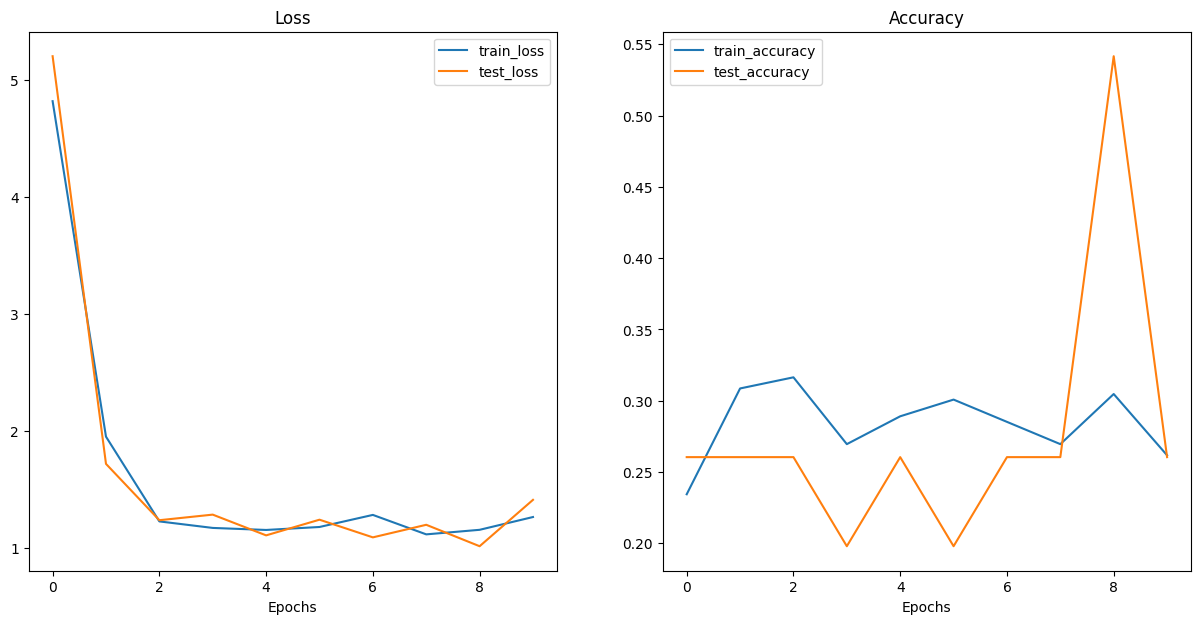

In [56]:
from helper_functions import plot_loss_curves

plot_loss_curves(results=results)

## Conclusion

We can aply the architecture and train it properly. But the lack of computational power and data used makes the model underfit (As shown in the loss / acc result). In the paperm, they used 1.3M images for ImageNet-1k, 14M images for ImageNet-21k, and 303M images for JFT while in this experimentation only have 225 images. A batch size of 4096 compared to the 32 we used and other things such as learning rate warmup, learning rate decaym and gradient clipping all of which is stated in the Table 3. 